In [8]:
import keras
from tcn import tcn
from keras.utils.io_utils import HDF5Matrix
import numpy as np
from keras.callbacks import History 
history = History()

model = tcn.dilated_tcn(output_slice_index='last', # try 'first'.
                                       num_feat=150,
                                       num_classes=8,
                                       nb_filters=18,
                                       kernel_size=20,
                                       dilatations=[1, 2, 4],
                                       nb_stacks=8,
                                       max_len=300,
                                       activation='wavenet')


# Using sparse softmax.
# http://chappers.github.io/web%20micro%20log/2017/01/26/quick-models-in-keras/
# model.summary()  

# Generator section
def data_generator(totalsamples, batchsize = 100):

    number_of_batches = totalsamples/batchsize
    start = 0
    while 1:
        X = HDF5Matrix('D:/Major Project/totaltraindataset.h5', 'traindata', start, start + batchsize)
        y = HDF5Matrix('D:/Major Project/totaltraindataset.h5', 'trainlabel', start, start + batchsize)
        start = start + batchsize

        x_train = np.copy(X)
        y_train = np.copy(y)
        y_train = y_train.squeeze().argmax(axis=1)
        yield (x_train,y_train)
        
        #restart counter to yeild data in the next epoch as well
        if start > number_of_batches:
            start = 0

# for layer in model.layers:
#     weights = layer.get_weights() # list of numpy arrays
vtrain = HDF5Matrix('D:/Major Project/testdataset.h5', 'testdata', 0, 300)
vtrain = np.copy(vtrain)
vtarget = HDF5Matrix('D:/Major Project/testdataset.h5', 'testlabel', 0, 300)
vtarget = np.copy(vtarget)
vtarget = vtarget.squeeze().argmax(axis=1)
# Early stopping for no progress in validation in loss
# es = EarlyStopping(monitor='val_acc', min_delta=0.1, patience=4, verbose=1, mode='auto')



getdata = data_generator(10940, 32)
model.fit_generator(generator = getdata, steps_per_epoch=341, epochs=10,
                    verbose=2, shuffle=True, callbacks=[history], validation_data = (vtrain, vtarget))



x.shape= (?, 18)
model.x = (?, 300, 150)
model.y = (?, 8)
Adam with norm clipping.
Epoch 1/10
 - 44s - loss: 1.2415 - acc: 0.5373 - val_loss: 1.7636 - val_acc: 0.4567
Epoch 2/10
 - 34s - loss: 0.4486 - acc: 0.8615 - val_loss: 1.9023 - val_acc: 0.4833
Epoch 3/10
 - 34s - loss: 0.1797 - acc: 0.9611 - val_loss: 2.1517 - val_acc: 0.5133
Epoch 4/10
 - 34s - loss: 0.0705 - acc: 0.9897 - val_loss: 2.3931 - val_acc: 0.5067
Epoch 5/10
 - 33s - loss: 0.0233 - acc: 0.9966 - val_loss: 2.6457 - val_acc: 0.5167
Epoch 6/10
 - 34s - loss: 0.0088 - acc: 0.9992 - val_loss: 2.9363 - val_acc: 0.5300
Epoch 7/10
 - 34s - loss: 0.0042 - acc: 0.9996 - val_loss: 3.0220 - val_acc: 0.5333
Epoch 8/10
 - 34s - loss: 0.0022 - acc: 0.9997 - val_loss: 3.1951 - val_acc: 0.5167
Epoch 9/10
 - 34s - loss: 0.0016 - acc: 0.9998 - val_loss: 3.3678 - val_acc: 0.5400
Epoch 10/10
 - 34s - loss: 0.0014 - acc: 0.9997 - val_loss: 3.2302 - val_acc: 0.5233


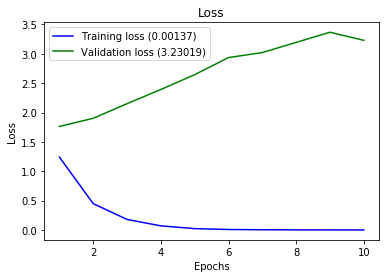

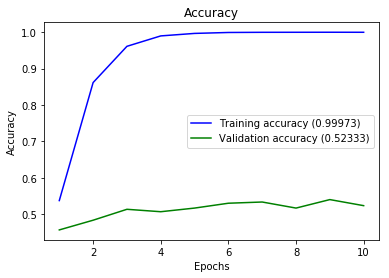

In [17]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
plot_history(history)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_class(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)

In [19]:
classes = ['drink water','brushing teeth','brushing hair','pickup','sitting down','hand waving','jump up','put palms together']
X = HDF5Matrix('D:/Major Project/testdataset.h5', 'testdata', 301, 376)
y = HDF5Matrix('D:/Major Project/testdataset.h5', 'testlabel', 301, 376)
x = np.copy(X)
y = np.copy(y)
y = y.squeeze().argmax(axis=1)

full_multiclass_report(model, x, y, classes)

AxisError: axis 1 is out of bounds for array of dimension 1